# Analysis of Oscillations

# Preliminaries

## Imports

In [1]:
import tellurium as te
import sympy
import matplotlib.pyplot as plt
import numpy as np
from common_python.sympy import sympyUtil as su
from common_python.ODEModel.ODEModel import ODEModel
import matplotlib.pyplot as plt

## Constants

In [2]:
su.addSymbols("S0 S1 S2 S3 S4 S5 S6 S7 S8 S9 k0 k1 k2 k3 k4 k5 k6 k7 k8 k9 k10 k11 k12 k13 k14 k15 k16 k17 k18 k19 k20")
su.addSymbols("J0 J1 J2 J3 J4 J5 J6 J7 J8 J9 J10 J11 J12 J13 J14 J15 J16 J`7 J18 J19 J20")
FLUXES = [J0, J1, J2, J3, J4, J5, J6, J7, J8, J9, J10, J11, J12, J13, J14, J15]
SPECIES = [S0, S1, S2, S3, S4, S5, S6, S7, S8]

In [3]:
MODEL = """
J0: S0 -> S2; k0*S0
J1: S3 + S3 -> S0; k5*S3*S3
J2: S2 -> S3; k6*S2
J3: S3 ->; k9*S2*S3
J4: -> S3; k10*S0
k0 = 6+0.9011095014634776
k5 = 1.4823891153952284
k6 = -10+15.149868787476994
k9 = 91.19197034598812
k10 = 200
S0 = 1.0
S1 = 5.0
S2 = 9.0
S3 = 3.0
S4 = 10.0
"""
RR = te.loada(MODEL)

# Helper Functions

In [4]:
# Create dictionary relating reaction names to species
def mkStoichiometryExpressionDct(rr):
    stoichiometryArr = rr.getFullStoichiometryMatrix()
    reactionNames = [n[1:] if n[0] == "_" else n for n in stoichiometryArr.colnames]
    stoichiometryArr.colnames = reactionNames
    speciesNames = stoichiometryArr.rownames
    dct = {}
    for idx, species in enumerate(speciesNames):
        sym = eval(species)
        entry = ["%d*%s" % (stoichiometryArr[idx, n], reactionNames[n]) for n in range(len(reactionNames))]
        expressionStr = " + ".join(entry)
        dct[sym] = eval(expressionStr)
        dct[sym] = sympy.simplify(dct[sym])
    return dct

# Tests
stoichiometryDct = mkStoichiometryExpressionDct(RR)
stoichiometryDct  

{S0: -J0 + J1, S2: J0 - J2, S3: -2*J1 + J2 - J3 + J4}

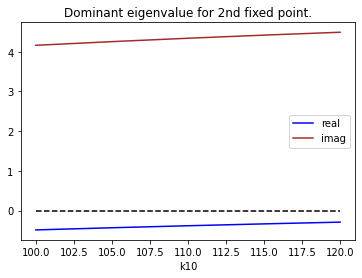

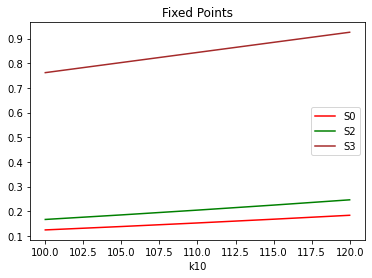

In [5]:
# Do plot
def plotEigenInfo(rr, title="", k10Range=None, fixedPointIdx=1, **kwargs):
    """
    Plots information about the dominant eigenvalue and fixed point for the
    indicated fixed point.
    
    Parameters
    ----------
    rr: ExtendedRoadrunner
    title: str
    k10Range: range of k10
    fixedPointIdx: int
        index of the fixed point to study
    kwargs: dict
        fractional adjustment in value
    """
    if k10Range is None:
        k10Range = [150 + v for v in range(60)]
    # Construct the data
    subDct = {k0: rr.k0, k5: rr.k5, k6: rr.k6, k9: rr.k9, k10: rr.k10}
    for key, value in kwargs.items():
        if isinstance(key, str):
            newKey = [s for s in subDct.keys() if s.name == key][0]
        else:
            newKey = key
        subDct[newKey] = subDct[newKey] * value
    xvs = []
    reals = []
    imags = []
    fixedPointDcts = []
    for c10 in k10Range: 
        subDct[k10] = c10
        dominantReal = None
        dominantImag = None
        modelInfo = ODEModel.mkODEModel(rr, subs=subDct, isEigenvecs=False)
        model = modelInfo.mdl
        #model = ODEModel(REDUCED_STATE_DCT, subs=subDct, isEigenvecs=False)
        # Find the dominant eigenvalue for the fixed points
        if len(model.fixedPoints) > fixedPointIdx:
            fixedPointDcts.append(dict(model.fixedPoints[fixedPointIdx].valueDct))
            # Find the dominant eigenvalue
            for entry in model.fixedPoints[fixedPointIdx].eigenEntries:
                value = entry.value
                if isinstance(value, complex):
                    real, imag = su.asRealImag(value)
                else:
                    real = value
                    imag = 0
                if (dominantReal is None) or (real > dominantReal):
                    dominantReal = real
                    dominantImag = np.abs(imag)
        xvs.append(c10)
        reals.append(dominantReal)
        imags.append(dominantImag)
    # Plot the dominant eigenvalue
    _, ax = plt.subplots(1)
    ax.plot(xvs, reals, color="blue")
    ax.plot(xvs, imags, color="brown")
    ax.plot([xvs[0], xvs[-1]], [0, 0], linestyle="--", color="black")
    ax.legend(["real", "imag"])
    ax.set_title(title)
    ax.set_xlabel("k10")
    # Plot the indexed fixed point
    states = list(fixedPointDcts[0].keys())
    _, ax = plt.subplots(1)
    COLORS = ["red", "green", "brown"]
    for idx, state in enumerate(states):
        yvs = [f[state] for f in fixedPointDcts]
        ax.plot(xvs, yvs, color=COLORS[idx])
    ax.legend(states)
    ax.set_title("Fixed Points")
    ax.set_xlabel("k10")
    return fixedPointDcts
    
# Test
dcts = plotEigenInfo(RR, k10Range=[100 + 5*v for v in range(5)], k9=1, title="Dominant eigenvalue for 2nd fixed point.")

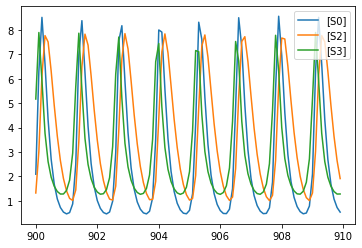

In [6]:
def runSim(model=MODEL, endTime=100, startTime=0, **kwargs):
    def findIdx(arr, time):
        """Finds the index of the time in the simulation results array."""
        bestIdx = 0
        diff = np.abs(arr[0, 0] - time)
        for idx, value in enumerate(arr[:, 0]):
            if np.abs(value - time) < diff:
                diff = np.abs(value - time)
                bestIdx = idx
        return bestIdx
    rr = te.loada(MODEL)
    # Adjust the parameters
    for key, value in kwargs.items():
        if isinstance(key, sympy.core.symbol.Symbol):
            newKey = s.name
        else:
            newKey = key
        rr[newKey] = rr[newKey] * value
    #rr.plot(rr.simulate(startTime, endTime, 10*endTime))
    arr = rr.simulate(0, endTime, 10*endTime)
    _, ax = plt.subplots(1)
    startIdx = findIdx(arr, startTime)
    endIdx = findIdx(arr, endTime)
    for idx in range(len(arr.colnames[1:])):
        ax.plot(arr[startIdx:endIdx,0], arr[startIdx:endIdx, idx+1])
    ax.legend(arr.colnames[1:])
    
# Tests
runSim(k9=0.5, startTime=900, endTime=910)

# Damped Model 2

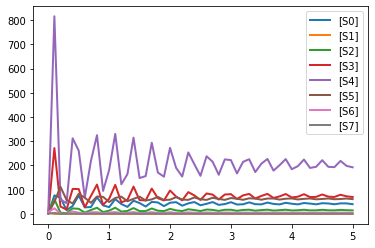

In [19]:
MODEL2 = """
var S0
var S1
var S2
var S3
var S4
var S5
var S6
var S7
ext S8
J0: S4 -> S7+S5; k0*S4
J1: S2 -> S4+S4; k1*S2
J2: S4 -> S3+S3; k2*S4
J3: S4 -> S2+S3; k3*S4
J4: S0 -> S5; k4*S0
J5: S5 + S4 -> S5; k5*S5*S4
J6: S5 -> S3; k6*S5
J7: S8 + S3 -> S0; k7*S8*S3
J8: S3 -> S6+S5; k8*S3
J9: S6 + S5 -> S4; k9*S6*S5
J10: S7 + S5 -> S0 + S2; k10*S7*S5
J11: S3 -> S5+S6; k11*S3
J12: S6 + S1 -> S5; k12*S6*S1
J13: S5 -> S5; k13*S5
J14: S1 + S7 -> S1 + S1; k14*S1*S7
k0 = 2.5920480618068815
k1 = 422.2728070204247
k2 = 28.978192374985912
k3 = 29.723263589242986
k4 = 21.04114996098882
k5 = 1.5111236529181926
k6 = 14.363185343334044
k7 = 0.8231126169112812
k8 = 54.27226867691914
k9 = 58.17954213283633
k10 = 10.682986014127339
k11 = 194.08273474192015
k12 = 15.989508525207631
k13 = 13.186614071108659
k14 = 35.67582901156382
S0 = 1.0
S1 = 5.0
S2 = 9.0
S3 = 3.0
S4 = 10.0
S5 = 3.0
S6 = 7.0
S7 = 1.0
S8 = 6.0
"""

rr = te.loada(MODEL2)
rr.plot(rr.simulate())

In [8]:
mat = sympy.Matrix(rr.getFullStoichiometryMatrix())
mat

Matrix([
[ 0.0,  0.0,  0.0,  0.0, -1.0,  0.0,  0.0,  1.0,  0.0,  0.0,  1.0,  0.0,  0.0, 0.0,  0.0],
[ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, -1.0, 0.0,  1.0],
[ 0.0, -1.0,  0.0,  1.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  1.0,  0.0,  0.0, 0.0,  0.0],
[ 0.0,  0.0,  2.0,  1.0,  0.0,  0.0,  1.0, -1.0, -1.0,  0.0,  0.0, -1.0,  0.0, 0.0,  0.0],
[-1.0,  2.0, -1.0, -1.0,  0.0, -1.0,  0.0,  0.0,  0.0,  1.0,  0.0,  0.0,  0.0, 0.0,  0.0],
[ 1.0,  0.0,  0.0,  0.0,  1.0,  0.0, -1.0,  0.0,  1.0, -1.0, -1.0,  1.0,  1.0, 0.0,  0.0],
[ 0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  1.0, -1.0,  0.0,  1.0, -1.0, 0.0,  0.0],
[ 1.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0,  0.0, -1.0,  0.0,  0.0, 0.0, -1.0]])

In [9]:
SPECIES_FLUX_DCT = mkStoichiometryExpressionDct(rr)
SPECIES_FLUX_DCT

{S0: J10 - J4 + J7,
 S1: -J12 + J14,
 S2: -J1 + J10 + J3,
 S3: -J11 + 2*J2 + J3 + J6 - J7 - J8,
 S4: -J0 + 2*J1 - J2 - J3 - J5 + J9,
 S5: J0 - J10 + J11 + J12 + J4 - J6 + J8 - J9,
 S6: J11 - J12 + J8 - J9,
 S7: J0 - J10 - J14}

In [10]:
nullspace = mat.nullspace()

In [11]:
# Kinetics dictionary
kineticDct = {
    J0:  k0*S4,
    J1:  k1*S2,
    J2:  k2*S4,
    J3:  k3*S4,
    J4:  k4*S0,
    J5:  k5*S5*S4,
    J6:  k6*S5,
    J7:  k7*S8*S3,
    J8:  k8*S3,
    J9:  k9*S6*S5,
    J10:  k10*S7*S5,
    J11:  k11*S3,
    J12:  k12*S6*S1,
    J13:  k13*S5,
    J14:  k14*S1*S7,
}

In [20]:
modelInfo = ODEModel.mkODEModel(rr, isFixedPoints=False, isEigenvecs=False)

In [23]:
# Note that S8 is external and so is constant
modelInfo.mdl.stateDct

{S0: -1.0*S0*k4 + 1.0*S3*S8*k7 + 1.0*S5*S7*k10,
 S1: 1.0*S1*(-S6*k12 + S7*k14),
 S2: -1.0*S2*k1 + 1.0*S4*k3 + 1.0*S5*S7*k10,
 S3: -1.0*S3*S8*k7 - 1.0*S3*k11 - 1.0*S3*k8 + 2.0*S4*k2 + 1.0*S4*k3 + 1.0*S5*k6,
 S4: 2.0*S2*k1 - 1.0*S4*S5*k5 - 1.0*S4*k0 - 1.0*S4*k2 - 1.0*S4*k3 + 1.0*S5*S6*k9,
 S5: 1.0*S0*k4 + 1.0*S1*S6*k12 + 1.0*S3*k11 + 1.0*S3*k8 + 1.0*S4*k0 - 1.0*S5*S6*k9 - 1.0*S5*S7*k10 - 1.0*S5*k6,
 S6: -1.0*S1*S6*k12 + 1.0*S3*k11 + 1.0*S3*k8 - 1.0*S5*S6*k9,
 S7: -1.0*S1*S7*k14 + 1.0*S4*k0 - 1.0*S5*S7*k10}

In [18]:
STATE_DCT = {s: SPECIES_FLUX_DCT[s].subs(kineticDct) for s in SPECIES_FLUX_DCT.keys() }
STATE_DCT

{S0: -S0*k4 + S3*S8*k7 + S5*S7*k10,
 S1: -S1*S6*k12 + S1*S7*k14,
 S2: -S2*k1 + S4*k3 + S5*S7*k10,
 S3: -S3*S8*k7 - S3*k11 - S3*k8 + 2*S4*k2 + S4*k3 + S5*k6,
 S4: 2*S2*k1 - S4*S5*k5 - S4*k0 - S4*k2 - S4*k3 + S5*S6*k9,
 S5: S0*k4 + S1*S6*k12 + S3*k11 + S3*k8 + S4*k0 - S5*S6*k9 - S5*S7*k10 - S5*k6,
 S6: -S1*S6*k12 + S3*k11 + S3*k8 - S5*S6*k9,
 S7: -S1*S7*k14 + S4*k0 - S5*S7*k10}

In [28]:
relaxationResult = su.mkQuadraticRelaxation(modelInfo.mdl.stateDct)
mat = sympy.simplify(relaxationResult.mat)
mat

Matrix([
[-1.0*k4,                        0,       0,                     1.0*S8*k7,                         0,       0,           0,          0,        0,        0,       0,       0,  1.0*k10],
[      0, -1.0*S6*k12 + 1.0*S7*k14,       0,                             0,                         0,       0, -1.0*S1*k12, 1.0*S1*k14,        0,        0,       0,       0,        0],
[      0,                        0, -1.0*k1,                             0,                    1.0*k3,       0,           0,          0,        0,        0,       0,       0,  1.0*k10],
[      0,                        0,       0, -1.0*S8*k7 - 1.0*k11 - 1.0*k8,           2.0*k2 + 1.0*k3,  1.0*k6,           0,          0,        0,        0,       0,       0,        0],
[      0,                        0,  2.0*k1,                             0, -1.0*k0 - 1.0*k2 - 1.0*k3,       0,           0,          0,        0,        0, -1.0*k5,  1.0*k9,        0],
[ 1.0*k4,                        0,       0,              1.0

In [42]:
relaxationResult.sub

{S1S6: S1*S6, S1S7: S1*S7, S4S5: S4*S5, S5S6: S5*S6, S5S7: S5*S7}

In [37]:
bVec = sympy.zeros(relaxationResult.mat.rows, 1)
nullResult = relaxationResult.mat.gauss_jordan_solve(bVec)

In [38]:
nullResult[1]

Matrix([
[tau0],
[tau1],
[tau2],
[tau3],
[tau4]])

In [39]:
nullResult[0]

Matrix([
[                                                                                                                                                                                          -tau2*(-1.0*S8*k0*k5*k7 - 2.0*S8*k2*k5*k7 - 1.0*S8*k3*k5*k7)/(1.0*k0*k11*k4 + 1.0*k0*k4*k8 + 1.0*k11*k2*k4 - 1.0*k11*k3*k4 + 1.0*k2*k4*k8 - 1.0*k3*k4*k8) - tau3*(-1.0*S8*k0*k7*k9 + 3.0*S8*k3*k7*k9)/(1.0*k0*k11*k4 + 1.0*k0*k4*k8 + 1.0*k11*k2*k4 - 1.0*k11*k3*k4 + 1.0*k2*k4*k8 - 1.0*k3*k4*k8) - tau4*(2.0*S8*k0*k10*k7 + 4.0*S8*k10*k2*k7 + 2.0*S8*k10*k3*k7 - 1.0*k0*k10*k11 - 1.0*k0*k10*k8 - 1.0*k10*k11*k2 + 1.0*k10*k11*k3 - 1.0*k10*k2*k8 + 1.0*k10*k3*k8)/(1.0*k0*k11*k4 + 1.0*k0*k4*k8 + 1.0*k11*k2*k4 - 1.0*k11*k3*k4 + 1.0*k2*k4*k8 - 1.0*k3*k4*k8)],
[                                                                                                                                                                                                                                                              

In [ ]:
# Construct the constraints

In [43]:
nullResult[0][1] * nullResult[0][6], nullResult[0][8]

(tau0*(-1.0*S1*k12*tau0/(1.0*S6*k12 - 1.0*S7*k14) + 1.0*S1*k14*tau1/(1.0*S6*k12 - 1.0*S7*k14)),
 -tau2*(-1.0*k0*k5 - 2.0*k2*k5 - 1.0*k3*k5)/(1.0*k0*k12 + 1.0*k12*k2 - 1.0*k12*k3) - tau3*(1.0*k2*k9 + 2.0*k3*k9)/(1.0*k0*k12 + 1.0*k12*k2 - 1.0*k12*k3) - tau4*(2.0*k0*k10 + 4.0*k10*k2 + 2.0*k10*k3)/(1.0*k0*k12 + 1.0*k12*k2 - 1.0*k12*k3))

In [49]:
nullResult[0][4]

2.0*k10*tau4/(1.0*k0 + 1.0*k2 - 1.0*k3) - 1.0*k5*tau2/(1.0*k0 + 1.0*k2 - 1.0*k3) + 1.0*k9*tau3/(1.0*k0 + 1.0*k2 - 1.0*k3)

In [50]:
nullResult[0][5]

-tau2*(-1.0*S8*k0*k5*k7 - 2.0*S8*k2*k5*k7 - 1.0*S8*k3*k5*k7 - 1.0*k0*k11*k5 - 1.0*k0*k5*k8 - 4.0*k11*k2*k5 - 2.0*k11*k3*k5 - 4.0*k2*k5*k8 - 2.0*k3*k5*k8)/(1.0*k0*k11*k6 + 1.0*k0*k6*k8 + 1.0*k11*k2*k6 - 1.0*k11*k3*k6 + 1.0*k2*k6*k8 - 1.0*k3*k6*k8) - tau3*(-1.0*S8*k0*k7*k9 + 3.0*S8*k3*k7*k9 - 1.0*k0*k11*k9 - 1.0*k0*k8*k9 + 2.0*k11*k2*k9 + 4.0*k11*k3*k9 + 2.0*k2*k8*k9 + 4.0*k3*k8*k9)/(1.0*k0*k11*k6 + 1.0*k0*k6*k8 + 1.0*k11*k2*k6 - 1.0*k11*k3*k6 + 1.0*k2*k6*k8 - 1.0*k3*k6*k8) - tau4*(2.0*S8*k0*k10*k7 + 4.0*S8*k10*k2*k7 + 2.0*S8*k10*k3*k7 + 2.0*k0*k10*k11 + 2.0*k0*k10*k8 + 8.0*k10*k11*k2 + 4.0*k10*k11*k3 + 8.0*k10*k2*k8 + 4.0*k10*k3*k8)/(1.0*k0*k11*k6 + 1.0*k0*k6*k8 + 1.0*k11*k2*k6 - 1.0*k11*k3*k6 + 1.0*k2*k6*k8 - 1.0*k3*k6*k8)

In [51]:
nullResult[0][10]

tau2

In [ ]:
su.solveLinearSingular(relaxationResult.mat, relaxationResult.vec, isParameterized=True)

In [ ]:
MODEL = ODEModel(STATE_DCT, isFixedPoints=False)

In [ ]:
# Need to find a linear combination of values in the null space
# such that the kinetic equations hold.
# Have N reactions, M species. So, N - M constants to find.
su.addSymbols("c c_0 c_1 c_2 c_3 c_4 c_5 c_6")
c = sympy.Matrix([c_0, c_1, c_2, c_3, c_4, c_5, c_6])
mat = sympy.Matrix(nullspace).reshape(15, 7)
mat * c

In [ ]:
105/7

In [ ]:
# Solve for log(S*)
exprs = [ j - b for j, b in zip(kineticDct.values(), mat*c) ]
exprs = [e.subs({S2: 0, S3: 0}) for e in exprs]
sympy.solve(exprs, [ S5])

**Approach**
1. $N$ =  stoichiometry matrix
1. $M$ = nullspace of $N$
1. Substitute 0 for any state variable that must be zero for all vectors $M \star c$.
1. Solve for log of $x_n$ (state variable) in terms of log of $J_n$ (fluxes)
1. We know that the fluxes for the fixed points must be in $M \star c$, where $c$ is a vector.
1. Substitute $J_n$ value from previous (5) into (4) to give an expression for $x_n$ in terms of $c_n$.

Issue: How do I find the $c_i$?

**Approach 2**
1. Solve for $x_n$ in terms of $J$

In [ ]:
# Looks like I can manually solve for most species
SPECIES_FLUX_DCT = {
    S0: J4/k4,
    S1: (J12/k12) /((J9 / k9) / (J6 / k6)),
    S2: J1 / k1,
    S3: J8 / k8,
    S4: J0 / k0,
    S5: J6 / k6,
    S6: (J9 / k9) / (J6 / k6),
    S7: (J10 / k10) / (J6 / k6),
    S8: (J7 / k7) / (J8 / k8),   
    
}

In [ ]:
dstateDct =  {s: SPECIES_FLUX_DCT[s].subs(kineticDct) for s in SPECIES_FLUX_DCT.keys()}

In [ ]:
dstateDct

# Reduced Model

In [52]:
su.addSymbols("S0 S1 S2 S3 S4 S5 S6")
su.addSymbols("k0 k1 k2 k3 k4 k5 k6 k7 k8 k9 k10 k11 k12 k13 k14 k15 k16 k17 k18 k19 k20")
su.addSymbols("J0 J1 J2 J3 J4 J5 J6 J7 J8 J9 J10 J11 J12 J13 J14 J15 J16 J`7 J18 J19 J20")
REDUCED_FLUXES = [J0, J1, J2, J3, J4]
REDUCED_SPECIES = [S0, S1, S2, S3, S4]

In [53]:
MODEL = """
J0: S0 -> S2; k0*S0
J1: S3 + S3 -> S0; k5*S3*S3
J2: S2 -> S3; k6*S2
J3: S3 ->; k9*S2*S3
J4: -> S3; k10*S0
k0 = 6+0.9011095014634776
k5 = 1.4823891153952284
k6 = -10+15.149868787476994
k9 = 91.19197034598812
k10 = 200
S0 = 1.0
S1 = 5.0
S2 = 9.0
S3 = 3.0
S4 = 10.0
"""

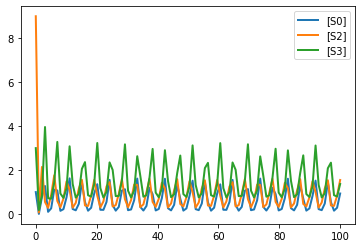

In [54]:
MODEL = """
J0: S0 -> S2; k0*S0
J1: S3 + S3 -> S0; k5*S3*S3
J2: S2 -> S3; k6*S2
J3: S3 ->; k9*S2*S3
J4: -> S3; k10*S0
k0 = (6+0.9011095014634776)
k5 = 1.4823891153952284
k6 = (-10+15.149868787476994)
k9 = 91.19197034598812  # At k9 * 0.5, use k10 = k155
k10 = 200 # 164, 165 ins a transition from damped to stable oscillations
S0 = 1.0
S2 = 9.0
S3 = 3.0
"""

rr = te.loada(MODEL)
rr.plot(rr.simulate(0, 100, 100)) 

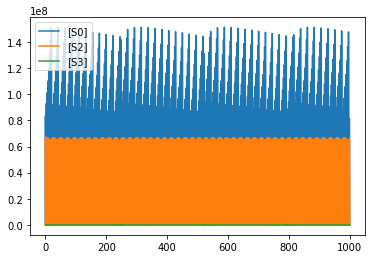

In [55]:
runSim(k9=0.5, k10=140, endTime=1000)

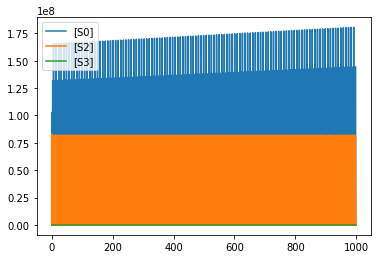

In [56]:
runSim(k9=0.5, k10=150, endTime=1000)

## Relaxation Analysis

1. Create a linear system by adding new variables for quadratics.
1. Find the nullspace of the linear system.
1. Solve for unknown constants using constraints.

In [59]:
modelInfo = ODEModel.mkODEModel(rr, isFixedPoints=False, isEigenvecs=False)

In [64]:
modelInfo.mdl.stateDct

{S0: -1.0*S0*k0 + 1.0*S3**2*k5,
 S2: 1.0*S0*k0 - 1.0*S2*k6,
 S3: 1.0*S0*k10 - 1.0*S2*S3*k9 + 1.0*S2*k6 - 2.0*S3**2*k5}

In [60]:
relaxationResult = su.mkQuadraticRelaxation(modelInfo.mdl.stateDct)
mat = sympy.simplify(relaxationResult.mat)
mat

Matrix([
[-1.0*k0,       0, 0,       0,  1.0*k5],
[ 1.0*k0, -1.0*k6, 0,       0,       0],
[1.0*k10,  1.0*k6, 0, -1.0*k9, -2.0*k5]])

In [68]:
nullVecs = mat.nullspace(relaxationResult.vec)
nullVecs

[Matrix([
 [0],
 [0],
 [1],
 [0],
 [0]]),
 Matrix([
 [                            1.0*k5/k0],
 [                            1.0*k5/k6],
 [                                    0],
 [-1.0*(1.0*k0*k5 - 1.0*k10*k5)/(k0*k9)],
 [                                    1]])]

In [61]:
relaxationResult.vec

Matrix([
[  S0],
[  S2],
[  S3],
[S2S3],
[S3S3]])

In [69]:
su.addSymbols("c_0 c_1")
nullVec = nullVecs[0]*c_0 + nullVecs[1] * c_1
nullVec

Matrix([
[                            1.0*c_1*k5/k0],
[                            1.0*c_1*k5/k6],
[                                      c_0],
[-1.0*c_1*(1.0*k0*k5 - 1.0*k10*k5)/(k0*k9)],
[                                      c_1]])

In [72]:
# Solve for the constraints
# Constraint 1: S2*S3 == S2S3
sympy.solve(nullVec[1] * nullVec[2] -   nullVec[3], [c_0, c_1])

[(c_0, 0.0), (k6*(-k0 + k10)/(k0*k9), c_1)]

In [73]:
# Solve for the constraints
# Constraint 2: S3*S3 == S3S3
sympy.solve(nullVec[2] * nullVec[2] -   nullVec[4], [c_0, c_1])

[(c_0, c_0**2)]

So, $c_0 = k_6 \frac{-k_0 + k_{10}}{k_0 k_9}$. $c_1 = c_0^2$.

**To do**
1. Verify these solutions.
1. Algorithm to find solutions automatically.

## Miscellaneous Analysis

In [57]:
plot1(k0=0.01, k5=0.1, k6=0.1, k9=0.1, base=100)

NameError: name 'plot1' is not defined

In [ ]:
REDUCED_SPECIES_FLUX_DCT = mkStoichiometryExpressionDct(rr)
REDUCED_SPECIES_FLUX_DCT

In [ ]:
kineticDct = {
    J0: k0 * S0,
    J1: k5 * S3 * S3,
    J2: k6 * S2,
    J3: k9 * S2 * S3,
    J4: k10*S0,  # Is this really mass action?
    
}

In [ ]:
# State equation is wrong for S2. Should be - S2*k6
REDUCED_STATE_DCT = {s: REDUCED_SPECIES_FLUX_DCT[s].subs(kineticDct) for s in REDUCED_SPECIES_FLUX_DCT.keys()}
REDUCED_STATE_DCT

In [ ]:
sympy.solve(list(REDUCED_STATE_DCT.values()), list(REDUCED_STATE_DCT.keys()))

In [ ]:
reducedModel = ODEModel(REDUCED_STATE_DCT)

In [ ]:
# Fixed points
[f.valueDct for f in reducedModel.fixedPoints]

In [ ]:
# Verify that these are fixed points
for fp in reducedModel.fixedPoints:
    print([sympy.simplify(e.subs(fp.valueDct)) for e in REDUCED_STATE_DCT.values()])

In [ ]:
# Look at the eigenvectors
if False:
    for entry in reducedModel.fixedPoints[1].eigenEntries:
        for vector in entry.vectors:
            print(vector)

In [ ]:
eigenvalues = [e.value for e in reducedModel.fixedPoints[1].eigenEntries]

**Approach**
1. Find the fixed points.
1. For non-zero fixed points:
    1. Find the eigenvalues in terms of each constant in turn, setting the other constants to 1.
    1. Search for values of constants that result in a positive but near zero real value and significant non-zero imaginary part

**Issue**
1. Eigenvalues have no relationship to the system behavior

## Finding Parameter Values

Given an ODEModel, find values of parameters that result in oscillations at different frequencies.

In [ ]:
c0 = rr.k0
c5 = rr.k5
c6 = rr.k6
c9 = rr.k9
c10 = rr.k10
for c10 in [150 + n for n in range(50)]:
    subDct = {k0: c0, k5: c5, k6: c6, k9: c9, k10: c10}
    model = ODEModel(REDUCED_STATE_DCT, subs=subDct)
    entries = model.fixedPoints[1].eigenEntries
    print((c10, [e.value for e in entries]))

## Plots

In [ ]:
dcts = plotEigenInfo(RR, k10Range=[100 + 5*v for v in range(25)], k9=1, title="Dominant eigenvalue for 2nd fixed point.")

In [ ]:
runSim(k10=100/200, startTime=0, endTime=10)

In [ ]:
runSim(k10=160/200, startTime=0, endTime=10)

In [ ]:
runSim(k9=1, k10=160/200, startTime=990, endTime=1000)

In [ ]:
runSim(k9=1, k10=170/200, startTime=990, endTime=1000)

In [ ]:
runSim(k9=1, k10=200/200, startTime=990, endTime=1000)

In [ ]:
4.5 / (2*np.pi)

In [ ]:
def plot1(base=150, **kwargs):
    k10Range=[base + 10*v for v in range(10)]
    title = ""
    for key, value in kwargs.items():
        title += " %s: %3.2f " % (str(key), value)
    plotComplexEigenvalue(rr, k10Range=k10Range, title=title, **kwargs)
    
plot1(k0=1, k5=1, k6=1, k9=1)

In [ ]:
plot1(k0=0.01, k5=0.1, k6=0.1, k9=0.1, base=100)

In [ ]:
plot1(k0=1, k5=1, k6=1, k9=0.5, base=100)


In [ ]:
runSim(k0=1, k5=1, k6=1, k9=0.5, k10=100, endTime=1000)

Am i excluding the dominant eigenvalue? Do the plots for all eigenvalues.